<a href="https://colab.research.google.com/github/NehaSontakk/GCN-Metabolic-Pathways/blob/main/PML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import os
import glob
import json
import pandas as pd
import numpy as np
from math import log, exp


In [36]:
module_id      = "M00001"
sample_name    = "3300060297_1"

In [37]:
# I have uploaded 10 graph examples to KEGG_Graphs_Generated

COMPLETENESS_CSV       = "Data/Contig_completeness.csv"
VK_CSV                 = "Data/KO_trusted_cutoff.csv"
KO_OCCURRENCES_TXT     = "Data/ko_occurences.txt"
ADJ_LINKS_JSON         = "Data/all_module_adjacency_links_Apr3.json"
neighbor_txt = "Data/ko_normalized_prediction.txt"
OUTPUT_EXCEL           = f"{module_id}_KO_table.xlsx"

In [38]:
MODULE_JSON_DIR = "KEGG_Graphs_Generated/"
nodes_path = f"{MODULE_JSON_DIR}/module_{module_id}_nodes.json"
with open(nodes_path) as f:
    module_nodes = json.load(f)

# Extract just the KO IDs in this module (base 6‐char codes)
module_kos = sorted({n.split("_",1)[0] for n in module_nodes if n.startswith("K")})


## Node Probability: Preparing for dk values for each KO

In [39]:
# completeness
df_comp = pd.read_csv(COMPLETENESS_CSV)
df_comp['sigma'] = 1 - ((np.exp(3 * df_comp['Completeness']) - 1) / np.exp(3))

# VK table
df_vk = pd.read_csv(VK_CSV)
df_vk['E_values_MAG']    = df_vk['E_values_MAG'].fillna(1e4)
df_vk['E_value_trusted'] = df_vk['E_value_trusted'].fillna(1e-5)
df_vk['Rk']   = df_vk['E_values_MAG'] / df_vk['E_value_trusted']
df_vk['Vk']   = df_vk['Rk'].apply(lambda x: max(0, -np.log10(x)))
df_vk['alphak'] = df_vk['Vk'].apply(lambda x: 1 - np.exp(-x / 5))
df_vk['q_half'] = df_vk['E_value_trusted'] * (10 ** -3.46574)


<ipython-input-39-41ea7be3629f>:10: RuntimeWarning: divide by zero encountered in log10
  df_vk['Vk']   = df_vk['Rk'].apply(lambda x: max(0, -np.log10(x)))


In [40]:
# merge in KO frequencies
ko_occ = pd.read_csv(KO_OCCURRENCES_TXT, sep="\s+",names=['KO id','occurences'])
ko_occ['KO_freq'] = ko_occ['occurences'] / 895

df_vk_prob = pd.merge(df_vk, ko_occ, on="KO id", how="left")
df_vk_prob['KO_freq'] = df_vk_prob['KO_freq'].fillna(1e-3)

# pick sigma for your sample
sigma_val = df_comp.loc[df_comp['filename']==sample_name, 'sigma'].iloc[0]

### Gamma KO FUNCTION & D KO

In [41]:
def gamma_func(row, t=np.float128(1e-5)):
    q = np.float128(row['E_value_trusted'])
    mag = np.float128(row['E_values_MAG'])
    qh = q * (np.float128(10) ** np.float128(-3.46574))
    alpha = np.float128(row['alphak'])
    if mag > t:
        return np.float128(0)
    elif mag > qh:
        return (np.log10(mag/t) / np.log10(qh/t)) * np.float128(0.5)
    else:
        return alpha

df_vk_prob['gamma_k'] = df_vk_prob.apply(gamma_func, axis=1)
df_vk_prob['Dk'] = df_vk_prob.apply(
    lambda r: r['gamma_k'] + (1 - r['gamma_k']) * sigma_val * r['KO_freq'],
    axis=1
)
df_vk_prob['sigma'] = sigma_val

<ipython-input-41-9058deff1e2e>:9: RuntimeWarning: divide by zero encountered in log10
  return (np.log10(mag/t) / np.log10(qh/t)) * np.float128(0.5)


In [42]:
nodes_path = os.path.join(MODULE_JSON_DIR, f"module_{module_id}_nodes.json")
with open(nodes_path) as f:
    module_nodes = json.load(f)

#  lookup
dk_dict = dict(zip(df_vk_prob['KO id'], df_vk_prob['Dk']))

module_nodes_with_DK = {}
for node, idx in module_nodes.items():
    if node.startswith("K"):
        base = node.split("_",1)[0]
        module_nodes_with_DK[node] = {
            "index": idx,
            "Dk": dk_dict.get(base, np.nan)
        }
    else:
        module_nodes_with_DK[node] = {"index": idx}

In [43]:
ko_set = {n.split("_",1)[0] for n in module_nodes if n.startswith("K")}
print(ko_set)
missing_kos = ko_set.difference(df_vk_prob['KO id'])

if missing_kos:
    # constant pieces we’ll reuse
    _defaults = {
        "E_value_trusted": 1e-5,
        "E_values_MAG":    1e4,
        "KO_freq":         1e-3,
        "sigma":           sigma_val        # use the same sigma for this sample
    }

    new_rows = []
    for ko in missing_kos:
        # recompute the derived columns exactly the same way
        Rk       = _defaults["E_values_MAG"] / _defaults["E_value_trusted"]
        Vk       = max(0, -np.log10(Rk))
        alphak   = 1 - np.exp(-Vk / 5)
        q_half   = _defaults["E_value_trusted"] * (10 ** -3.46574)

        # γ_k with the same rules as `gamma_func`
        t        = np.float128(1e-5)
        mag128   = np.float128(_defaults["E_values_MAG"])
        qh128    = np.float128(q_half)
        if mag128 > t:
            gamma_k = 0.0                     # falls into the first branch of gamma_func
        elif mag128 > qh128:
            gamma_k = (np.log10(mag128/t) / np.log10(qh128/t)) * 0.5
        else:
            gamma_k = alphak

        # finally D_k
        Dk = gamma_k + (1 - gamma_k) * sigma_val * _defaults["KO_freq"]

        new_rows.append({
            "KO id": ko,
            "E_value_trusted": _defaults["E_value_trusted"],
            "E_values_MAG":    _defaults["E_values_MAG"],
            "Rk":              Rk,
            "Vk":              Vk,
            "alphak":          alphak,
            "q_half":          q_half,
            "gamma_k":         gamma_k,
            "KO_freq":         _defaults["KO_freq"],
            "sigma":           sigma_val,
            "Dk":              Dk
        })

    # append to the main probability table
    df_vk_prob = pd.concat([df_vk_prob, pd.DataFrame(new_rows)],
                           ignore_index=True)

{'K11645', 'K24182', 'K01624', 'K00134', 'K01834', 'K00844', 'K00873', 'K06859', 'K01623', 'K12407', 'K00886', 'K13810', 'K15634', 'K16370', 'K25026', 'K27394', 'K00150', 'K01803', 'K11389', 'K16306', 'K00927', 'K00850', 'K15635', 'K12406', 'K00918', 'K01810', 'K08074', 'K15916', 'K21071', 'K16305', 'K01689', 'K15633', 'K00845'}


In [44]:
filtered = df_vk_prob[df_vk_prob['KO id'].isin(ko_set)]
cols = ['KO id','E_value_trusted','E_values_MAG','Rk','Vk',
        'alphak','q_half','gamma_k','KO_freq','sigma','Dk']
filtered[cols].to_excel(OUTPUT_EXCEL, index=False)
print(f"KO table written to {OUTPUT_EXCEL}")

KO table written to M00001_KO_table.xlsx


In [45]:
filtered[cols]

/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,KO id,E_value_trusted,E_values_MAG,Rk,Vk,alphak,q_half,gamma_k,KO_freq,sigma,Dk
659,K08074,1.000000e-05,1.000000e+04,1.000000e+09,0.000000,0.000000,3.421842e-09,0.000000,0.001000,0.712293,0.000712
1073,K00850,2.065414e-103,4.000000e-114,1.936658e-11,10.712947,0.882649,7.067521e-107,0.882649,0.644693,0.712293,0.936538
2607,K00844,1.382663e-50,2.600000e+00,1.880429e+50,0.000000,0.000000,4.731255e-54,0.000000,0.025698,0.712293,0.018305
2953,K01689,4.744747e-77,2.900000e-199,6.112022e-123,122.213815,1.000000,1.623578e-80,1.000000,0.998883,0.712293,1.000000
3092,K01803,1.000000e-05,3.900000e-99,3.900000e-94,93.408935,1.000000,3.421842e-09,1.000000,0.998883,0.712293,1.000000
4069,K00134,3.024290e-122,2.600000e-145,8.597059e-24,23.065650,0.990079,1.034864e-125,0.990079,0.934078,0.712293,0.996680
5407,K00845,3.820119e-35,1.200000e-20,3.141264e+14,0.000000,0.000000,1.307184e-38,0.226873,0.385475,0.712293,0.439151
5439,K00873,4.157856e-12,1.400000e-169,3.367120e-158,157.472741,1.000000,1.422753e-15,1.000000,0.948603,0.712293,1.000000
5651,K24182,1.000000e-05,2.000000e-13,2.000000e-08,7.698970,0.785575,3.421842e-09,0.785575,0.001000,0.712293,0.785727
6098,K01623,1.026380e-08,1.000000e+04,9.742978e+11,0.000000,0.000000,3.512111e-12,0.000000,0.144134,0.712293,0.102666


### Path probabilities

In [55]:
def compute_path_probability(path, dk_dict):
    """Return *Dk over all KO‑nodes in the path."""
    prob = np.float128(1.0)
    for node in path:
        if '_' in node:
            koid = node.split('_', 1)[0]
            prob *= np.float128(dk_dict.get(koid, 1.0))
    return prob

def score_path(path, dk_dict, *, alpha=0.6):
    raw_p = compute_path_probability(path, dk_dict)      # 0 < raw_p ≤ 1
    L = sum(1 for n in path if 'K' in n)                 # # of KO nodes

    if raw_p == 0:                                       # defensive
        log_p        = -np.inf
        avg_log_p    = -np.inf
        lenpen_score = -np.inf
    else:
        log_p        = float(np.log(raw_p))              # natural‑log domain
        avg_log_p    = log_p / L                         # geometric‑mean normalisation
        lenpen_score = log_p / (L ** alpha)              # Google‑style length penalty

    return {
        "L": L,
        "raw_prob"       : float(raw_p),                 # still handy to keep
        "log_prob"       : log_p,                        # Σ log pᵢ
        "avg_log_prob"   : avg_log_p,                    # (Σ log pᵢ)/L
        "geo_mean_prob"  : exp(avg_log_p),               # e^{AvgLogP}
        "lenpen_score"   : lenpen_score                  # Σ log pᵢ / L^α
    }

paths_path = f"{MODULE_JSON_DIR}/module_{module_id}_paths.json"
print("Loading:", paths_path)
with open(paths_path) as f:
    paths_dict = json.load(f)


rows_og = []
for key, comma_str in sorted(paths_dict.items(), key=lambda x: int(x[0])):
    path_nodes = [n.strip() for n in comma_str.split(',')]
    sc         = score_path(path_nodes, dk_dict)
    rows_og.append({
        "path_id":      int(key),
        "path":         " -> ".join(path_nodes),
        "raw_prob":     sc["raw_prob"],
        "avg_log_prob": sc["avg_log_prob"],
        "geo_mean_prob":sc["geo_mean_prob"],
        "lenpen_score": sc["lenpen_score"],
    })

df_path_before_diffusion = (
    pd.DataFrame(rows_og)
      .set_index("path_id")
      .sort_index()
)

'''
for key, comma_str in sorted(paths_dict.items(), key=lambda x:int(x[0])):
    path = [n.strip() for n in comma_str.split(',')]
    #print(path)
    sc = score_path(path, dk_dict)
    print(f"Path {key}: {' -> '.join(path)}")
    print("  raw_prob:",    f"{sc['raw_prob']:.6f}")
    print("  avg_log_prob:", f"{sc['avg_log_prob']:.4f}")
    print("  geo_mean_prob:",f"{sc['geo_mean_prob']:.6f}")
    print("  lenpen_score:", f"{sc['lenpen_score']:.4f}")
    #print(f"Path {key}: raw={sc['raw']:.4e}, avg_log={sc['avg_log']:.4f}, lenpen={sc['lenpen']:.4f}")
'''

df_path_before_diffusion.sort_values(by="geo_mean_prob",ascending=False)

Loading: KEGG_Graphs_Generated//module_M00001_paths.json


,path,raw_prob,avg_log_prob,geo_mean_prob,lenpen_score
path_id,,,,,
37806,K00886_5 -> K01810_8 -> K21071_14 -> K11645_19...,9.159298e-01,-0.008782,0.991257,-0.022058
2562,K00886_5 -> K01810_8 -> K21071_14 -> K11645_19...,9.159298e-01,-0.008782,0.991257,-0.022058
33329,K00886_5 -> K01810_8 -> K21071_14 -> K11645_19...,9.159298e-01,-0.008782,0.991257,-0.022058
42938,K00886_5 -> K01810_8 -> K21071_14 -> K11645_19...,9.159298e-01,-0.008782,0.991257,-0.022058
33345,K00886_5 -> K15916_11 -> K21071_14 -> K11645_1...,9.157703e-01,-0.008799,0.991240,-0.022102
...,...,...,...,...,...
4478,K08074_6 -> K13810_10 -> K00918_16 -> K16305_2...,4.874259e-15,-3.295481,0.037050,-8.277874
3884,K12407_2 -> K13810_10 -> K00918_16 -> K16305_2...,4.874259e-15,-3.295481,0.037050,-8.277874
14752,K00918_7 -> K13810_10 -> K00918_16 -> K16305_2...,4.874259e-15,-3.295481,0.037050,-8.277874


In [56]:
neighbors = {}

with open(neighbor_txt, 'r') as f:
    for line in f:
        line = line.strip()
        if not line or not line.startswith("K"):
            continue
        ko, idx, nbrs_str = line.split(":", 2)
        ko = ko.strip()
        entries = [e.strip() for e in nbrs_str.split(",") if e.strip()]
        nbr_list = []
        for entry in entries:
            nbr_id, weight_str = entry.split(":")
            w = float(weight_str)
            # clamp zero weights to 0.001
            if w == 0.0:
                w = 0.001
            nbr_list.append((nbr_id.strip(), w))
        neighbors[ko] = nbr_list


In [57]:
dk_dict = dict(zip(df_vk_prob['KO id'], df_vk_prob['Dk']))

In [58]:
neighbors.get('K00844',0)

[('K01835', 1.0),
 ('K12406', 0.001),
 ('K15635', 0.65),
 ('K01834', 1.0),
 ('K13810', 0.001),
 ('K00873', 0.78),
 ('K24182', 0.001),
 ('K15633', 0.65),
 ('K11389', 0.001),
 ('K01810', 1.0),
 ('K15778', 0.001),
 ('K27394', 0.001),
 ('K00918', 0.001),
 ('K00134', 1.0),
 ('K00886', 0.001),
 ('K15779', 0.001),
 ('K01623', 0.001),
 ('K00972', 0.13),
 ('K12447', 0.001),
 ('K16370', 0.001),
 ('K01624', 1.0),
 ('K01803', 1.0),
 ('K12407', 0.001),
 ('K25026', 0.65),
 ('K00150', 0.001),
 ('K00850', 0.78),
 ('K00963', 0.13),
 ('K00927', 1.0),
 ('K11645', 0.65),
 ('K15916', 0.001),
 ('K08074', 0.001),
 ('K00820', 0.78),
 ('K06859', 0.001),
 ('K00845', 0.001),
 ('K21071', 0.65),
 ('K00621', 0.13),
 ('K01836', 0.001),
 ('K01689', 1.0),
 ('K16305', 0.001),
 ('K16306', 0.001),
 ('K15634', 0.001)]

In [59]:
alpha = 0.6
records = []
for ko in module_kos:
    old_p = dk_dict.get(ko, np.nan)
    nbrs  = neighbors.get(ko, [])
    # unpack
    nbr_ids = [u for u,_ in nbrs]
    wts     = [w for _,w in nbrs]
    dks     = [dk_dict.get(u,0.0) for u in nbr_ids]

    #neighbor trust
    print(max(wts))
    T = alpha*max(wts)
    print(T)

    # GCN
    num = sum(w*d for w,d in zip(wts,dks))
    den = sum(wts) or 1.0
    raw_gcn = (1-T)*old_p + T*(num/den)
    new_gcn = max(old_p, raw_gcn)

    records.append({
        'KO id':                 ko,
        'Dk for KO':             old_p,
        'Neighbors':             nbrs,
        'Weights':               wts,
        'Dk for each neighbor':  [f'{d:0.4f}' for d in dks],
        'Calculated GCN': raw_gcn,
        'Final GCN':             new_gcn
    })

1.0
0.6
1.0
0.6
1.0
0.6
1.0
0.6
1.0
0.6
1.0
0.6
1.0
0.6
0.001
0.0006
1.0
0.6
1.0
0.6
1.0
0.6
1.0
0.6
1.0
0.6
1.0
0.6
1.0
0.6
1.0
0.6
0.001
0.0006
0.001
0.0006
1.0
0.6
0.001
0.0006
0.001
0.0006
0.001
0.0006
1.0
0.6
1.0
0.6
1.0
0.6
1.0
0.6
0.001
0.0006
0.001
0.0006
1.0
0.6
1.0
0.6
0.001
0.0006
1.0
0.6
0.001
0.0006


In [60]:
df_gcn = pd.DataFrame(records)

In [61]:
df_gcn

,KO id,Dk for KO,Neighbors,Weights,Dk for each neighbor,Calculated GCN,Final GCN
0,K00134,0.996680,"[(K00883, 0.25), (K01601, 0.001), (K12406, 0.0...","[0.25, 0.001, 0.001, 0.04, 0.001, 0.81, 0.54, ...","[0.1655, 0.0007, 1.0000, 0.0247, 1.0000, 0.978...",0.900612,0.996680
1,K00150,0.999983,"[(K01601, 0.001), (K12406, 0.001), (K15635, 0....","[0.001, 0.001, 0.001, 0.001, 0.73, 0.001, 1.0,...","[0.0007, 1.0000, 0.0247, 1.0000, 0.9789, 0.016...",0.927367,0.999983
2,K00844,0.018305,"[(K01835, 1.0), (K12406, 0.001), (K15635, 0.65...","[1.0, 0.001, 0.65, 1.0, 0.001, 0.78, 0.001, 0....","[1.0000, 1.0000, 0.0247, 0.9789, 0.0167, 1.000...",0.535793,0.535793
3,K00845,0.439151,"[(K01835, 0.71), (K12406, 0.001), (K15635, 0.0...","[0.71, 0.001, 0.001, 0.79, 0.001, 0.98, 0.97, ...","[1.0000, 1.0000, 0.0247, 0.9789, 0.0167, 0.746...",0.692189,0.692189
4,K00850,0.936538,"[(K12406, 0.001), (K15635, 0.05), (K01834, 0.8...","[0.001, 0.05, 0.86, 0.001, 0.99, 0.001, 0.71, ...","[1.0000, 0.0247, 0.9789, 0.0167, 1.0000, 0.785...",0.897191,0.936538
5,K00873,1.000000,"[(K12406, 0.001), (K15635, 0.03), (K01834, 0.8...","[0.001, 0.03, 0.8, 0.001, 0.001, 0.59, 0.001, ...","[1.0000, 0.0247, 0.9789, 0.0167, 0.7857, 1.000...",0.934336,1.000000
6,K00886,0.916375,"[(K01835, 0.83), (K12406, 0.001), (K15635, 0.0...","[0.83, 0.001, 0.001, 0.86, 0.001, 1.0, 0.001, ...","[1.0000, 1.0000, 0.0247, 0.9789, 0.0167, 1.000...",0.897790,0.916375
7,K00918,0.000712,"[(K12406, 0.001), (K15635, 0.001), (K01834, 0....","[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0...","[1.0000, 0.0247, 0.9789, 0.0167, 1.0000, 0.785...",0.001069,0.001069
8,K00927,1.000000,"[(K00883, 0.23), (K01601, 0.001), (K12406, 0.0...","[0.23, 0.001, 0.001, 0.03, 0.001, 0.77, 0.5, 0...","[0.1655, 0.0007, 1.0000, 0.0247, 1.0000, 0.978...",0.903077,1.000000
9,K01623,0.102666,"[(K01601, 0.001), (K12406, 0.001), (K15635, 0....","[0.001, 0.001, 0.001, 0.001, 0.86, 0.001, 1.0,...","[0.0007, 1.0000, 0.0247, 1.0000, 0.9789, 0.016...",0.569296,0.569296


In [62]:
df_gcn.to_excel("gcn_all_n.xlsx")

### GCN path probabilities

In [63]:
gcn_dict = dict(zip(df_gcn['KO id'], df_gcn['Final GCN']))

In [64]:
rows = []
for key in sorted(paths_dict, key=lambda x: int(x)):
    path_nodes = [n.strip() for n in paths_dict[key].split(',')]
    sc         = score_path(path_nodes, gcn_dict)          # returns dict of scores
    rows.append({
        "path_id":      int(key),
        "path":         " -> ".join(path_nodes),
        "raw_prob":     sc["raw_prob"],
        "avg_log_prob": sc["avg_log_prob"],
        "geo_mean_prob":sc["geo_mean_prob"],
        "lenpen_score": sc["lenpen_score"],
    })

df_paths = (
    pd.DataFrame(rows)
      .set_index("path_id")
      .sort_index()
)


In [65]:
df_paths.sort_values(by="geo_mean_prob",ascending=False).to_excel("paths_post_gcn.xlsx")

In [66]:
df_paths.to_excel("paths_post_gcn.xlsx")

In [67]:
for key in sorted(paths_dict, key=lambda x: int(x)):
    path = [n.strip() for n in paths_dict[key].split(',')]
    sc   = score_path(path, gcn_dict)
    print(f"Path {key}: {' -> '.join(path)}")
    print("  raw_prob:",    f"{sc['raw_prob']:.6f}")
    print("  avg_log_prob:", f"{sc['avg_log_prob']:.4f}")
    print("  geo_mean_prob:",f"{sc['geo_mean_prob']:.6f}")
    print("  lenpen_score:", f"{sc['lenpen_score']:.4f}")

Streaming output truncated to the last 5000 lines.
Path 43801: K00918_7 -> K06859_9 -> K21071_14 -> K01624_18 -> K01803_22 -> K00134_23 -> K11389_26 -> K15635_30 -> K27394_32 -> K00873_33
  raw_prob: 0.000000
  avg_log_prob: -2.2058
  geo_mean_prob: 0.110159
  lenpen_score: -5.5408
Path 43802: K25026_4 -> K06859_9 -> K16370_13 -> K11645_19 -> K01803_22 -> K00134_23 -> K11389_26 -> K15634_29 -> K27394_32 -> K12406_34
  raw_prob: 0.000000
  avg_log_prob: -1.4982
  geo_mean_prob: 0.223522
  lenpen_score: -3.7634
Path 43803: K00918_7 -> K15916_11 -> K00918_16 -> K01624_18 -> K01803_22 -> K00150_24 -> K11389_26 -> K15633_28 -> K27394_32 -> K12406_34
  raw_prob: 0.000000
  avg_log_prob: -2.7622
  geo_mean_prob: 0.063153
  lenpen_score: -6.9383
Path 43804: K00918_7 -> K13810_10 -> K21071_14 -> K01623_17 -> K01803_22 -> K00134_23 -> K11389_26 -> K15635_30 -> K01689_31 -> K00873_33
  raw_prob: 0.000000
  avg_log_prob: -1.8960
  geo_mean_prob: 0.150161
  lenpen_score: -4.7627
Path 43805: K00844_

In [68]:
import os
import glob
import json
import pandas as pd
import numpy as np
from math import log, exp

def compute_path_probability(path, dk_map):
    p = np.float128(1.0)
    for node in path:
        if '_' in node:
            ko = node.split('_',1)[0]
            p *= np.float128(dk_map.get(ko, 1.0))
    return p

def score_path(path, dk_map, *, alpha=0.6):
    raw_p = compute_path_probability(path, dk_map)
    L = sum(1 for n in path if 'K' in n)
    if raw_p == 0:
        return {"raw_prob": 0.0}
    log_p = float(np.log(raw_p))
    avg_log = log_p / L
    geo_mean = exp(avg_log)
    lenpen = log_p / (L ** alpha)
    return {
        "raw_prob": raw_p,
        "avg_log_prob": avg_log,
        "geo_mean_prob": geo_mean,
        "lenpen_score": lenpen
    }

# (2) Loop over every module_*_paths.json in KEGG_Graphs_Generated folder
paths_files = glob.glob(os.path.join(MODULE_JSON_DIR, "module_*_paths.json"))

all_rows = []

for paths_fp in paths_files:
    # extract module_id, e.g. "M00010"
    module_id = os.path.basename(paths_fp).split("_")[1]

    # load paths
    with open(paths_fp) as f:
        paths_dict = json.load(f)

    # load module nodes to find which KOs belong to it
    nodes_fp = os.path.join(MODULE_JSON_DIR, f"module_{module_id}_nodes.json")
    with open(nodes_fp) as f:
        module_nodes = json.load(f)
    module_kos = sorted({n.split("_",1)[0]
                         for n in module_nodes
                         if n.startswith("K")})

    # GCN‐updated Dk just for this module’s KOs
    alpha = 0.6
    gcn_map = {}
    for ko in module_kos:
        old_p = dk_dict.get(ko, np.nan)
        nbrs  = neighbors.get(ko, [])
        wts   = [w for _,w in nbrs]
        dks   = [dk_dict.get(u, 0.0) for u,_ in nbrs]

        T = alpha * (max(wts) if wts else 0.0)
        num = sum(w*d for w,d in zip(wts, dks))
        den = sum(wts) or 1.0
        raw_gcn = (1 - T)*old_p + T*(num/den)
        gcn_map[ko] = max(old_p, raw_gcn)

    #for each path, score before and after GCN
    for key, comma_str in sorted(paths_dict.items(), key=lambda x: int(x[0])):
        path_nodes = [n.strip() for n in comma_str.split(',')]
        sb = score_path(path_nodes, dk_dict)
        sa = score_path(path_nodes, gcn_map)

        all_rows.append({
            "module_id":           module_id,
            "path_id":             int(key),
            "path":                " -> ".join(path_nodes),
            "raw_prob_before_gcn": sb["raw_prob"],
            "raw_prob_after_gcn":  sa["raw_prob"]
        })


df_all = pd.DataFrame(all_rows)

# e.g. write to Excel or CSV:
df_all.to_excel("all_modules_paths_gcn_comparison.xlsx", index=False)

print(df_all.head())


  module_id  path_id                                               path  \
0    M00002        1  K01803_1 -> K00134_2 -> K00927_4 -> K01834_6 -...   
1    M00002        2  K01803_1 -> K00150_3 -> K00927_4 -> K01834_6 -...   
2    M00002        3  K01803_1 -> K00134_2 -> K00927_4 -> K01834_6 -...   
3    M00002        4  K01803_1 -> K00134_2 -> K11389_5 -> K15635_9 -...   
4    M00002        5  K01803_1 -> K00150_3 -> K11389_5 -> K01834_6 -...   

   raw_prob_before_gcn  raw_prob_after_gcn  
0         6.949791e-04        1.025283e-03  
1         9.789261e-01        9.789261e-01  
2         9.756929e-01        9.756929e-01  
3         1.247585e-08        5.894973e-07  
4         4.966690e-07        1.099712e-06  


## ANALYSIS POST GCN

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance, entropy

In [70]:
def load_and_clean(path):
    df = pd.read_excel(path) if path.lower().endswith(('.xls', '.xlsx')) else pd.read_csv(path)

    df['before'] = pd.to_numeric(df['raw_prob_before_gcn'], errors='coerce')
    df['after']  = pd.to_numeric(df['raw_prob_after_gcn'],  errors='coerce')
    return df.dropna(subset=['before','after']).reset_index(drop=True)

df = load_and_clean("all_modules_paths_gcn_comparison.xlsx")

In [71]:
#Prepare distibutions

def prepare_pmf(arr, eps=1e-12):
    a = np.nan_to_num(arr.astype(float), nan=0.0, posinf=0.0, neginf=0.0)
    a += eps
    total = a.sum()
    if total <= 0 or not np.isfinite(total):
        raise ValueError(f"Invalid sum {total}")
    return a / total

p = prepare_pmf(df['before'].values)
q = prepare_pmf(df['after'].values)

In [72]:
#Global metrics

w1 = wasserstein_distance(np.arange(len(p)), np.arange(len(q)), u_weights=p, v_weights=q)
kl = entropy(p, q)

print(f"Wasserstein-1: {w1:.6f}")
print(f"KL(p‖q):       {kl:.6f}")

Wasserstein-1: 690.133505
KL(p‖q):       0.638687


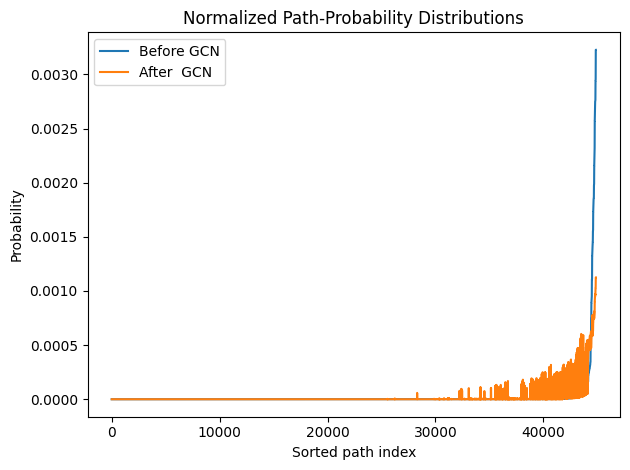

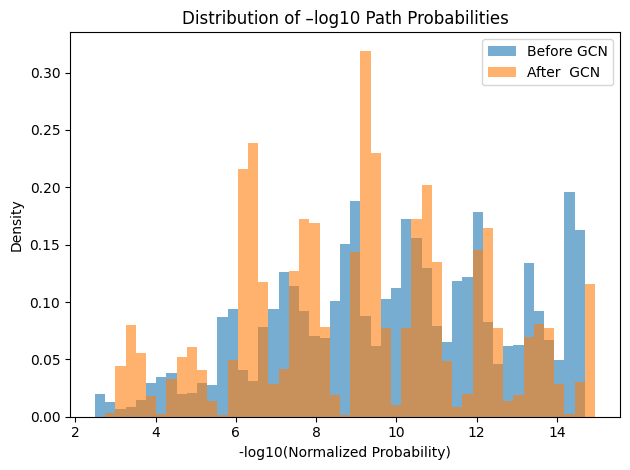

In [73]:
def plot_distributions(p, q):
    # a) Sorted PMF
    idx = np.argsort(p)
    plt.figure()
    plt.plot(p[idx], label='Before GCN')
    plt.plot(q[idx], label='After  GCN')
    plt.xlabel("Sorted path index")
    plt.ylabel("Probability")
    plt.title("Normalized Path-Probability Distributions")
    plt.legend()
    plt.tight_layout()

    # b) –log10 PMF
    plt.figure()
    lp, lq = -np.log10(p), -np.log10(q)
    bins = np.linspace(min(lp.min(), lq.min()), max(lp.max(), lq.max()), 50)
    plt.hist(lp, bins=bins, density=True, alpha=0.6, label='Before GCN')
    plt.hist(lq, bins=bins, density=True, alpha=0.6, label='After  GCN')
    plt.xlabel("-log10(Normalized Probability)")
    plt.ylabel("Density")
    plt.title("Distribution of –log10 Path Probabilities")
    plt.legend()
    plt.tight_layout()

plot_distributions(p, q)
plt.show()

In [74]:
def best_paths(df, col):
    idx = df.groupby('module_id')[col].idxmax()
    return df.loc[idx, ['module_id', 'path_id', 'path', col]].set_index('module_id')

best_before = best_paths(df, 'before')
best_after  = best_paths(df, 'after')

best = best_before.join(best_after, lsuffix='_b', rsuffix='_a')
best['changed'] = best['path_id_b'] != best['path_id_a']

print(f"\nModules changed best path: {best['changed'].sum()} / {len(best)}")


Modules changed best path: 0 / 2



Node changes per module:
count    2.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: node_changes, dtype: float64


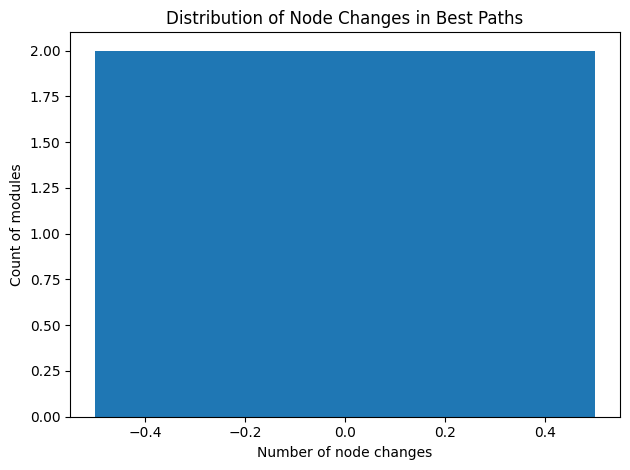

In [75]:
def count_node_changes(pb, pa):
    b = [n.strip() for n in pb.split('->')]
    a = [n.strip() for n in pa.split('->')]
    return len(set(b) ^ set(a))

best['node_changes'] = best.apply(lambda r: count_node_changes(r['path_b'], r['path_a']), axis=1)

print("\nNode changes per module:")
print(best['node_changes'].describe())

# Histogram of node-changes
plt.figure()
plt.hist(best['node_changes'], bins=range(int(best['node_changes'].max())+2), align='left')
plt.xlabel("Number of node changes")
plt.ylabel("Count of modules")
plt.title("Distribution of Node Changes in Best Paths")
plt.tight_layout()
plt.show()

In [76]:
#Frequency by positions

<ipython-input-77-fee2596ecda5>:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  diff_df = pd.DataFrame(diffs).fillna(False)


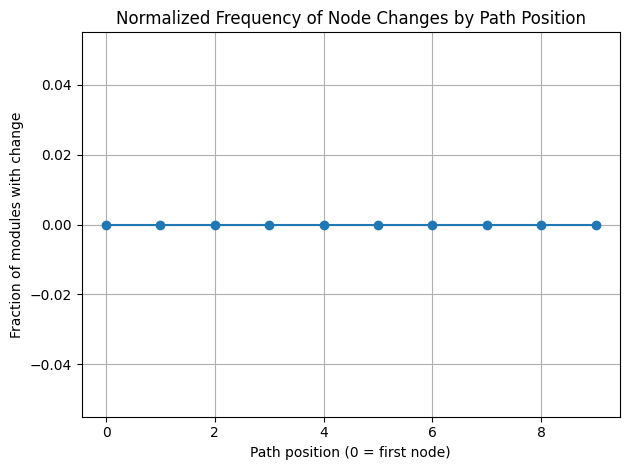

In [77]:
diffs = []
lengths = []
for _, row in best.iterrows():
    b_nodes = row['path_b'].split('->')
    a_nodes = row['path_a'].split('->')
    maxlen = max(len(b_nodes), len(a_nodes))
    diffs.append([(i < len(b_nodes) and i < len(a_nodes) and b_nodes[i]!=a_nodes[i])
                  or (i >= len(b_nodes) or i >= len(a_nodes))
                  for i in range(maxlen)])
    lengths.append(maxlen)

# Create DataFrame
diff_df = pd.DataFrame(diffs).fillna(False)
M_i = pd.Series((np.array(lengths) > diff_df.columns.values[:,None]).sum(axis=1),
                index=diff_df.columns)
C_i = diff_df.sum(axis=0)
F_i = C_i / M_i

plt.figure()
plt.plot(F_i.index, F_i.values, marker='o')
plt.xlabel("Path position (0 = first node)")
plt.ylabel("Fraction of modules with change")
plt.title("Normalized Frequency of Node Changes by Path Position")
plt.grid(True)
plt.tight_layout()
plt.show()